# Topic Analysis
This notbeook contains all of the code for aggregation of topics from the first two HITS. It takes in the data from the first 2 HITs, and then outputs the overall topic knowledge of mTurk.

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('wordbatch2.csv')
hit2 = pd.read_csv('hit_2_output.csv')
df.head()
word_list = []
for index, row in df.iterrows():
    for ans in range(1,5):
        word = row['Answer.topic_'+str(ans)]
        if isinstance(word, str):
            word_list.append(word)

## HIT1 Data Analysis
Here we have all of the word submitted from HIT1 in the variable word_list. With these words, we will run word2Vec and k-means clustering. Looking at the center of each of those clusters, this should give us an idea of what topics Turkers know about in the aggregate. Many words from the first HIT will not be present in word2Vec, which we ignore for now. Those words will be looked at again in HIT 2.

In [3]:
import gensim.models.keyedvectors as word2vec
from sklearn.cluster import KMeans
import numpy as np


filename = 'GoogleNews-vectors-negative300.bin'
#word_list = ['soccer', 'futbol','football', 'politics','Chelsea','elections','stocks','electronics','India','prime-minister','Champions-league']
model = word2vec.KeyedVectors.load_word2vec_format(filename, binary=True)
unknowns = []
knowns = []
knames = []
#word_list = dic_list
for i in range(len(word_list)):
    try:
        knowns.append(model[word_list[i]])
        knames.append(word_list[i])
    except:
        unknowns.append(word_list[i])
    for j in range(len(word_list)):
        if word_list[j] not in unknowns:
            try:
                print (str(word_list[i])+ ", "+str(word_list[j])+ ": " + str(model.similarity(word_list[i],word_list[j])))
            except:
                unknowns.append(word_list[j])

dists = []
K = range(1,25)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(knowns)
    dists.append(km.inertia_)

kmeans = KMeans(n_clusters=np.argmin(dists), random_state=0).fit(knowns)
labels = kmeans.labels_

Using these clusters, we made the categories used for HIT 2. We posted a HIT which asked turkers to classify all of the words which word2vec could not idenfity, and asked them to classify it as one of the topics which were present from our clustering analysis. We also added an other and don't know option in case the turkers didn't know what the word was.

## Aggregating HIT 2 and HIT 1 into Turker Topic Analysis
Here we combine the results from HIT 1 and HIT 2 in order to get a full concept of what topics turkers know about.

In [11]:
count = {}
total = 0
for index, row in hit2.iterrows():
    for col in range(49,130):
        category = hit2.columns[col]
        if row[category] == True:
            #point of the last period in the column
            p = category.rfind(".")
            topic = category[p+1:]
            num = category[p-1:p]
            
            add = 2
            if row["Answer.expertise_"+num+".high"]:
                add = 3
            elif  row["Answer.expertise_"+num+".med"]:
                add = 2
            elif  row["Answer.expertise_"+num+".high"]:
                add = 1
            total += add
            if topic in count:
                count[topic] += add
            else:
                count[topic] = add

for word in knames:
    max_topic = ''
    max_cs = -1
    for topic in count:
        if topic == "dont_know" or topic == "other_sports" or topic == "video_games":
            continue
        cs = model.similarity(word, topic)
        if cs > max_cs:
            max_cs = cs
            max_topic = topic
    count[max_topic] += 6
    total += 6
    
for topic in count:
    count[topic] /= total
    count[topic] *= 100

In [12]:
count

{'art': 3.2411288069293094,
 'baseball': 1.8943839061190275,
 'basketball': 2.112321877619447,
 'cooking': 2.8890751606594023,
 'dont_know': 1.5982117910030735,
 'education': 8.533109807208717,
 'finance': 4.235820061469684,
 'football': 3.056719754121263,
 'gardening': 2.347024308466052,
 'hobby': 7.974294495669182,
 'literature': 4.498463257893266,
 'math': 1.4138027381950267,
 'movies': 2.442022911427773,
 'music': 4.660519698239732,
 'nutrition': 4.3419949706621965,
 'other': 10.930427493713328,
 'other_sports': 3.3137747974294496,
 'parenting': 3.028778988544286,
 'pets': 2.905839620005588,
 'photography': 1.587035484772283,
 'politics': 3.352891869237217,
 'religion': 1.7546800782341436,
 'science': 3.7999441184688463,
 'soccer': 1.7546800782341436,
 'technology': 6.543727298127969,
 'television': 2.78290025146689,
 'video_games': 3.006426376082705}

These are the categories used to create the bar chart below

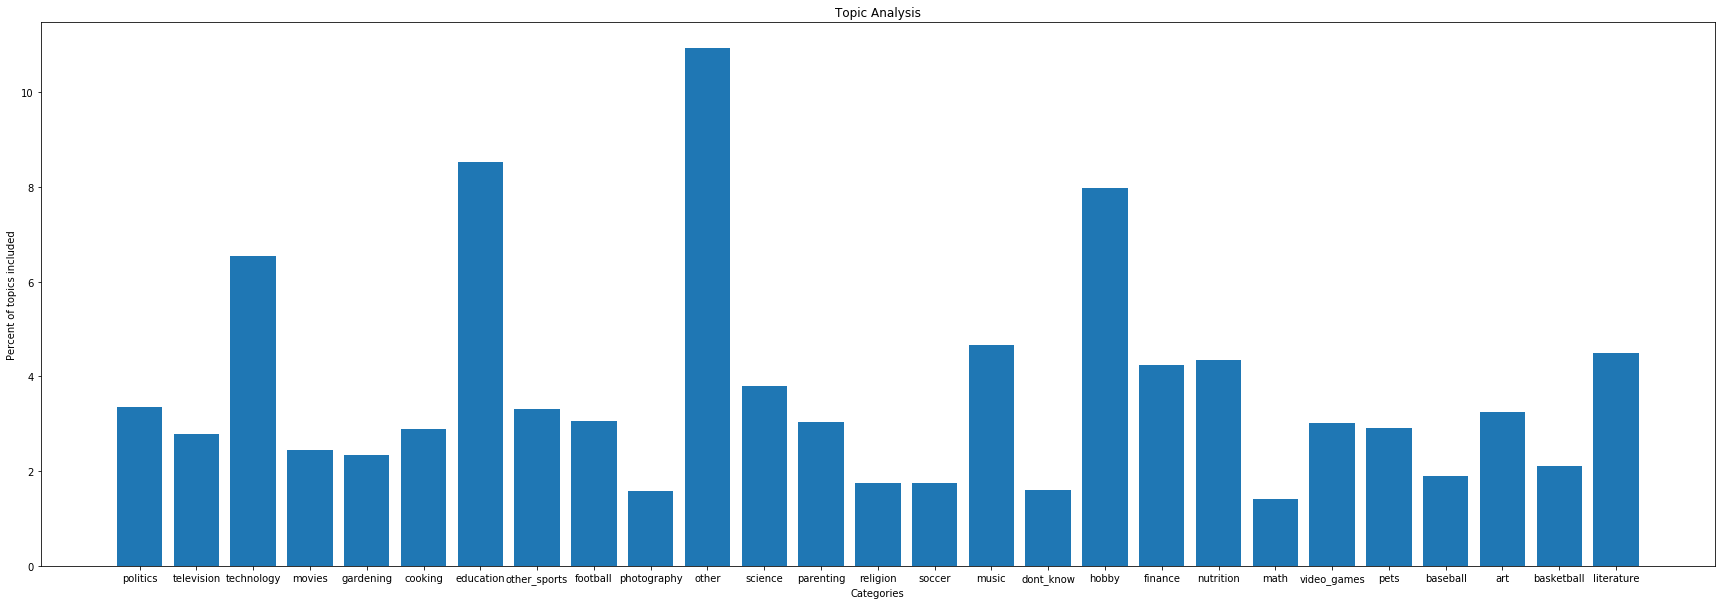

In [38]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,10))
plt.bar(list(count.keys()),list(count.values()))
plt.xlabel("Categories")
plt.ylabel("Percent of topics included")
plt.title("Topic Analysis")
plt.show()

## HIT1 Topic Analysis

Here we run KMeans to create the inital topic analysis

In [41]:
dists = []
K = range(1,30)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(knowns)
    dists.append(km.inertia_)

kmeans = KMeans(n_clusters=np.argmin(dists), random_state=0).fit(knowns)
labels = kmeans.labels_

In [42]:
np.argmin(dists)

28

In [43]:
n = 0
top_words = []
for c in range(np.argmin(dists)):
    cluster_words = []
    for i in range(len(knowns)):
        if(kmeans.labels_[i] == c):
            cluster_words.append(knowns[i])    
    top3 = model.most_similar(positive=cluster_words, topn=3)
    top_words.append(top3[0])
    print(top3)
    n += 1

[('Psychology', 0.8638474941253662), ('Biology', 0.78260338306427), ('Sociology', 0.7774052023887634)]
[('Gardening', 0.9782292246818542), ('gardening', 0.8355257511138916), ('vegetable_gardening', 0.7094038128852844)]
[('Basketball', 0.9838793277740479), ('Volleyball', 0.7359228134155273), ('Softball', 0.6746788024902344)]
[('Computers', 0.9329081773757935), ('Computer', 0.7407127618789673), ('computers', 0.7210654616355896)]
[('Football', 0.9206256866455078), ('Soccer', 0.759657621383667), ('Sports', 0.7445812821388245)]
[('Books', 0.9537973403930664), ('Comics', 0.6984010934829712), ('Bookshop', 0.6527296304702759)]
[('quilting', 0.8138535022735596), ('crochet', 0.8109740018844604), ('Crochet', 0.8107221126556396)]
[('Dogs', 0.8305302858352661), ('Animals', 0.802953839302063), ('animals', 0.7576248645782471)]
[('Art', 0.8011147975921631), ('Poetry', 0.7656776905059814), ('Printmaking', 0.7116436958312988)]
[('dol##.net_index###.html_http_dol##.net', 0.721744954586029), ('http_dol##.

In [5]:
len(unknowns)

1481

In [40]:
top_words

NameError: name 'top_words' is not defined

In [95]:
tot_cor = [0] * np.argmin(dists)
avg_cor = [0] * np.argmin(dists)
n_clust = [0] * np.argmin(dists)
for i in range(len(knowns)):
    ilabel = kmeans.labels_[i]
    tot_cor[ilabel] += model.similarity(knames[i], top_words[ilabel][0])
    n_clust[ilabel] += 1
for i in range(np.argmin(dists)):
    avg_cor[i] = (top_words[i][0],tot_cor[i] / n_clust[i], n_clust[i])

First number is correlation, second number is the number in the cluster

In [97]:
avg_cor

[('Psychology', 0.5902997267246246, 25),
 ('Gardening', 0.8739158287644386, 8),
 ('Basketball', 0.8944290369749069, 10),
 ('Computers', 0.6778482715288798, 15),
 ('Football', 0.7235963066418966, 15),
 ('Books', 0.7705943385759989, 9),
 ('quilting', 0.64513512807233, 14),
 ('Dogs', 0.6069824719115308, 19),
 ('Art', 0.5185368433594704, 24),
 ('dol##.net_index###.html_http_dol##.net', 0.22521802884037212, 59),
 ('Music', 0.5956941715752085, 24),
 ('Math', 0.6399184749885038, 11),
 ('Cooking', 0.7989143297076226, 20),
 ('basketball', 0.6462114139607078, 19),
 ('Photography', 0.7102544486522675, 15),
 ('Hiking', 0.9999999403953552, 3),
 ('WHOLE_NEW', 0.6414718429247538, 9),
 ('Finance', 0.48592983434597653, 18),
 ('Parenting', 0.8735541755502875, 11),
 ('Baseball', 0.8824196265024298, 17),
 ('Education', 0.4810661762952805, 15),
 ('Soccer', 0.8205217309296131, 16),
 ('Investing', 0.7309124916791916, 4),
 ('Fishing', 0.8161789874235789, 3),
 ('Nutrition', 0.6005270860411904, 11),
 ('Reddit',

In [46]:
random_clust = []
rnames = []
for i in range(len(knowns)):
    if(kmeans.labels_[i] == 10):
        random_clust.append(knowns[i])  
        rnames.append(knames[i])

rdists = []
rK = range(1,5)
for k in rK:
    rkm = KMeans(n_clusters=k).fit(random_clust)
    rdists.append(rkm.inertia_)

rkmeans = KMeans(n_clusters=np.argmin(rdists), random_state=0).fit(random_clust)
labels = kmeans.labels_

rtop_words = []
for c in range(np.argmin(rdists)):
    cluster_words = []
    for i in range(len(random_clust)):
        if(rkmeans.labels_[i] == c):
            cluster_words.append(random_clust[i])    
    top3 = model.most_similar(positive=cluster_words, topn=1)
    rtop_words.append(top3[0])

rtot_cor = [0] * np.argmin(rdists)
ravg_cor = [0] * np.argmin(rdists)
rn_clust = [0] * np.argmin(rdists)
for i in range(len(random_clust)):
    ilabel = rkmeans.labels_[i]
    rtot_cor[ilabel] += model.similarity(rnames[i], rtop_words[ilabel][0])
    rn_clust[ilabel] += 1
for i in range(np.argmin(rdists)):
    ravg_cor[i] = (rtop_words[i][0],rtot_cor[i] / rn_clust[i], rn_clust[i])

In [50]:
len(rand_d)

9

In [40]:
rand_c = []
for i in range(len(knowns)):
    if(kmeans.labels_[i] == 9):
        rand_c.append(knames[i])

In [48]:
x = np.concatenate([rand_c,rand_d])

In [7]:
final_data = pd.DataFrame(unknowns)

In [8]:
final_data.to_csv(r'just_unknowns.csv')